In [23]:
#Generate data
import numpy as np

synthetic_data = np.empty((50*49,3))

x = np.linspace(1,20,50)
y = np.linspace(10,40,50)

for i in range(len(x)-1):
    for j in range(len(y)-1):
        synthetic_data[i+j*50-1,:] = np.array([x[i],y[j],(x[i]-11)**2-(y[j]-15)**2])
np.savetxt('nparr.csv',synthetic_data,delimiter=',')

<IPython.core.display.Javascript object>


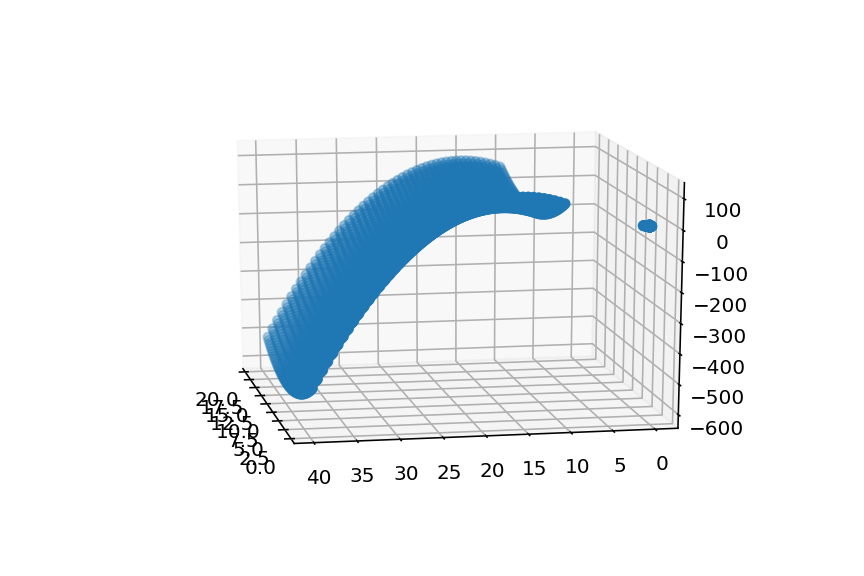

In [13]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:,0], synthetic_data[:,1], synthetic_data[:,2])